In [16]:
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import numpy as np
import glob
from astropy.table import Table
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import cm
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
homedir = os.path.expanduser('~')
def normalized_cmap(val, low, high, cmap):
    cmap = plt.get_cmap(cmap)
    rang=high-low
    return cmap(int((val-low)*255/rang))
c = 2.99792e5 # km/s

from config_run import goodchips_run

### Binned BTSettl fits

In [2]:
datadir = f"{homedir}/uoedrive/result/CIFIST"
instru = "IGRINS"
target = "W1049B"
band = "K"
tag = "bounds"

In [3]:
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
modellist = []
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chipmods_*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chiplams_*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['lte014.0-5.0', 'lte014.0-5.5', 'lte015.0-5.0', 'lte015.0-5.5', 'lte015.5-5.0', 'lte015.5-5.5', 'lte016.0-5.0', 'lte016.0-5.5', 'lte016.5-5.0', 'lte016.5-5.5', 'lte017.0-5.0', 'lte017.0-5.5', 'lte017.5-5.0', 'lte017.5-5.5', 'lte018.0-5.0', 'lte018.0-5.5', 'lte018.5-5.0', 'lte018.5-5.5'])

In [4]:
# find best fitting model
df = pd.DataFrame({
    'model name':[model for model in modellist], 
    'median':[np.median(chisq[model]) for model in modellist], 
    'mean':[np.mean(chisq[model]) for model in modellist], 
    'min':[np.min(chisq[model]) for model in modellist]
})
df = df.sort_values(by=['median'])
df.style.format({'median': '{:.0f}'.format, 'mean': '{:.0f}'.format,'min': '{:.0f}'.format,}).hide(axis="index")

model name,median,mean,min
lte016.5-5.5,13782243165,17730517065,5103494637
lte015.5-5.0,14056400226,17675907648,5804130846
lte015.5-5.5,14178456462,18249005249,6051140721
lte017.0-5.5,14288610080,17877483162,5245919472
lte017.5-5.5,14525749996,18069712833,4868577365
lte018.0-5.5,14623534731,18229112437,4701637403
lte015.0-5.5,14675639552,21199649199,4802770772
lte016.0-5.5,14761492370,18049840866,6037491001
lte016.5-5.0,14840356598,18784320450,4702756047
lte017.0-5.0,15099246432,19037015516,4522592214


In [12]:
chiplams[modelname][0,:,0]

array([2.45250863, 2.41933113, 2.38705941, 2.35565717, 2.32509005,
       2.29532546, 2.26633248, 2.23808177, 2.21054544, 2.18369699,
       2.1575112 , 2.13196407, 2.10703276, 2.08269549, 2.05893147,
       2.03572092, 2.01304491, 1.99088538, 1.96922508, 1.9480475 ])

In [94]:
model = 'lte015.5-5.5'
nobs = 14
vsini_2d = np.array(np.around(vsini[model].reshape((nobs, 20)), 1))
rv_2d = np.array(np.around(rv[model].reshape((nobs, 20)) * c, 1))
lld_2d = np.array(np.around(lld[model].reshape((nobs, 20)), 2))

#remove outliers
thres = 3
print("vsini outliers:", vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres])
vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres] = np.nan
print("rv outliers:", rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres])
rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres] = np.nan
print("lld outliers:", lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres])
lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres] = np.nan

indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

masked_vsini = vsini_2d[indices,:]
masked_rv = rv_2d[indices,:]
masked_lld = lld_2d[indices,:]

for i, jj in enumerate(range(20)):
    print(f"order {jj}\
    vsini: {np.nanmedian(vsini_2d[:,i]):.1f} ± {np.nanstd(vsini_2d[:,i]):.1f} km/s\
    rv: {np.nanmedian(rv_2d[:,i]):.1f} ± {np.nanstd(rv_2d[:,i]):.1f} km/s\
    lld: {np.nanmedian(lld_2d[:,i]):.2f} ± {np.nanstd(lld_2d[:,i]):.2f}")

print(f"all orders: \
    vsini: {np.nanmedian(vsini_2d):.1f} ± {np.nanstd(vsini_2d):.1f}\
    rv: {np.nanmedian(rv_2d):.1f} ± {np.nanstd(rv_2d):.1f}\
    lld: {np.nanmedian(lld_2d):.2f} ± {np.nanstd(lld_2d):.2f}")

print(f"all orders w/o bad t:\
    vsini: {np.nanmedian(masked_vsini):.1f} ± {np.nanstd(masked_vsini):.1f}\
    rv: {np.nanmedian(masked_rv):.1f} ± {np.nanstd(masked_rv):.1f}\
    lld: {np.nanmedian(masked_lld):.2f} ± {np.nanstd(masked_lld):.2f}")

vsini outliers: [ 79.8 100.  100.  100.   62.9]
rv outliers: [97.4 -8.4  6.4 43.2]
lld outliers: []
order 0    vsini: 26.9 ± 8.2 km/s    rv: 25.0 ± 2.2 km/s    lld: 0.45 ± 0.43
order 1    vsini: 26.3 ± 7.4 km/s    rv: 24.9 ± 3.3 km/s    lld: 0.44 ± 0.41
order 2    vsini: 25.5 ± 8.0 km/s    rv: 24.6 ± 2.6 km/s    lld: 0.29 ± 0.36
order 3    vsini: 28.1 ± 7.4 km/s    rv: 24.8 ± 3.7 km/s    lld: 0.73 ± 0.41
order 4    vsini: 27.6 ± 6.4 km/s    rv: 25.1 ± 2.5 km/s    lld: 0.51 ± 0.39
order 5    vsini: 26.0 ± 7.1 km/s    rv: 24.9 ± 3.1 km/s    lld: 0.86 ± 0.36
order 6    vsini: 26.6 ± 7.4 km/s    rv: 23.5 ± 2.2 km/s    lld: 0.38 ± 0.26
order 7    vsini: 27.8 ± 7.2 km/s    rv: 24.4 ± 2.0 km/s    lld: 0.62 ± 0.36
order 8    vsini: 26.0 ± 6.5 km/s    rv: 24.3 ± 2.4 km/s    lld: 0.39 ± 0.37
order 9    vsini: 26.3 ± 6.8 km/s    rv: 23.7 ± 2.4 km/s    lld: 0.54 ± 0.38
order 10    vsini: 26.7 ± 7.6 km/s    rv: 23.9 ± 2.3 km/s    lld: 0.65 ± 0.43
order 11    vsini: 25.8 ± 7.3 km/s    rv: 24.2 ± 2.3

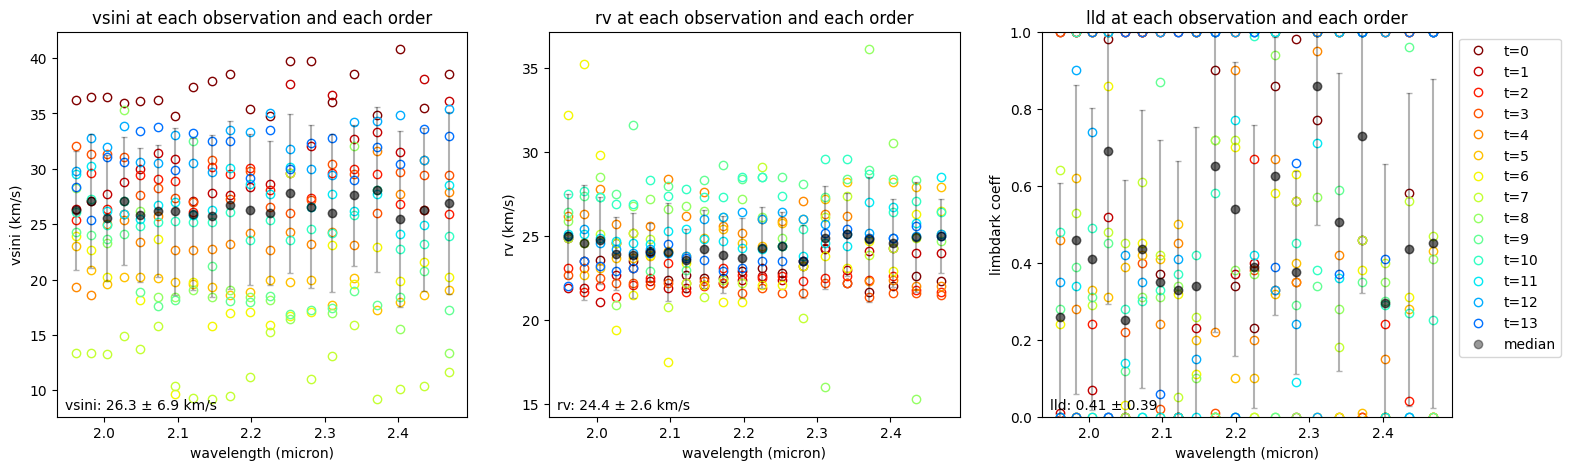

In [95]:
# vsini and rv for bestfittin model
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
colors = [cm.jet_r(x) for x in np.linspace(0, 1, nobs+4)]
vsini_points = masked_vsini
rv_points = masked_rv
lld_points = masked_lld
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl

for i, t in enumerate(indices):
    plt.plot(lam_points[:], vsini_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(vsini_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(vsini_points, axis=0), yerr=np.nanstd(vsini_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("vsini (km/s)")
plt.title("vsini at each observation and each order")
plt.text(0.02, 0.02, f"vsini: {np.nanmedian(vsini_points)} ± {np.nanstd(vsini_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,2)
for i, t in enumerate(indices):
    plt.plot(lam_points, rv_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(rv_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(rv_points, axis=0), yerr=np.nanstd(rv_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("rv (km/s)")
plt.title("rv at each observation and each order")
plt.text(0.02, 0.02, f"rv: {np.nanmedian(rv_points)} ± {np.nanstd(rv_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,3)
for i, t in enumerate(indices):
    plt.plot(lam_points, lld_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(lld_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(lld_points, axis=0), yerr=np.nanstd(lld_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("limbdark coeff")
plt.ylim(0, 1)
plt.title("lld at each observation and each order")
plt.text(0.02, 0.02, f"lld: {np.nanmedian(lld_points):.2f} ± {np.nanstd(lld_points):.2f}", transform=plt.gca().transAxes)
plt.legend(loc=2, bbox_to_anchor=(1,1));

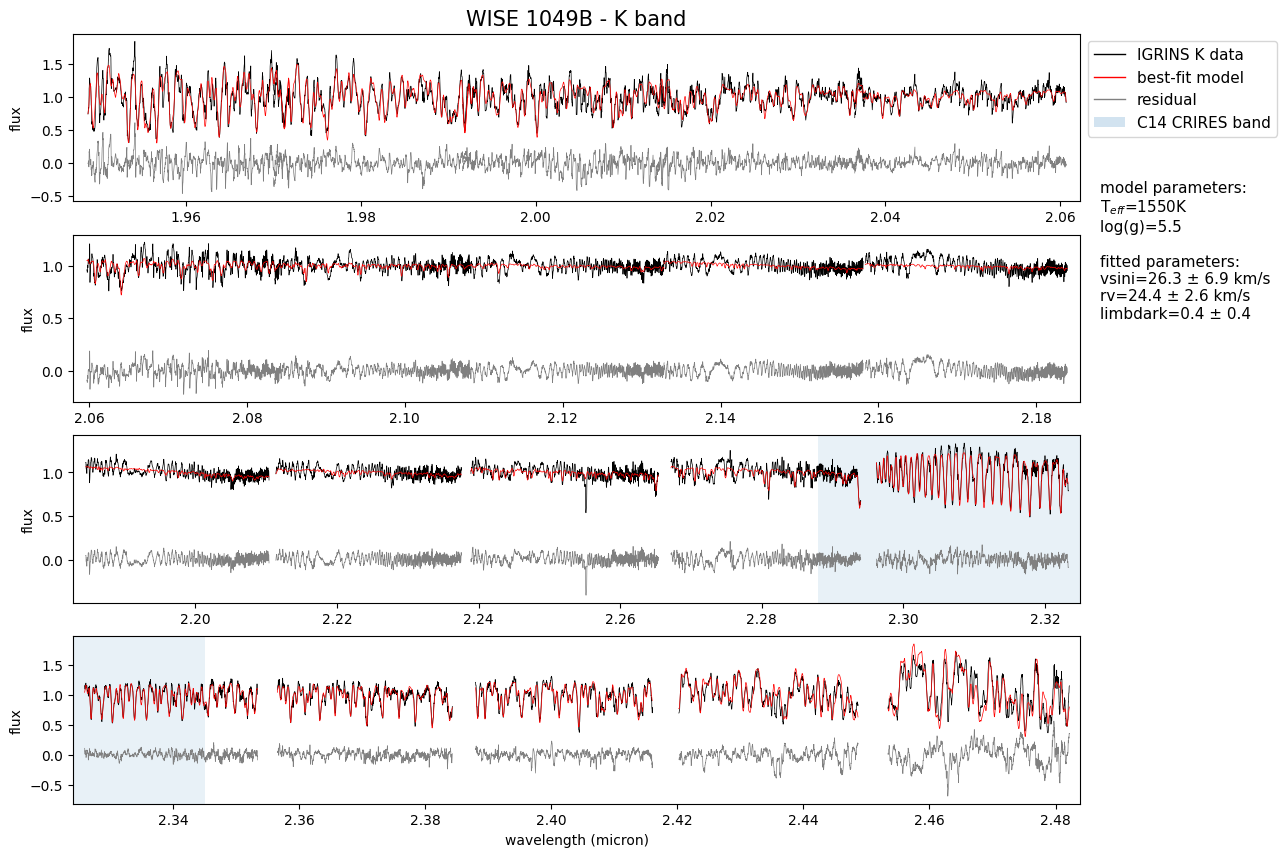

In [96]:
# plot best fitting spectrum
pad = 50
bfit_filename = f'IGRINS_W1049B_K_{model}.pickle'
with open(f"{datadir}/{bfit_filename}", 'rb') as f:
    ret = pickle.load(f, encoding="latin1")
fobs = ret['fobs0']
fobs = fobs[:20]
wobs = ret['wobs']
plt.figure(figsize=(13,10))
Teff = eval(model[3:8])*100
logg = model[9:12]

t=5
for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj, pad:-pad], linewidth=0.5, color="black", label="observation")
        plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj,pad:-pad] - chipmods[model][t,jj,pad:-pad], linewidth=0.5, color="gray", label="residual")
        if jj in indices:
            plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="best-fit model")
        else:
            plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="discarded orders")
    plt.ylabel("flux")
    l, r = plt.xlim(chiplams[model][t,sub*5+4].min()-0.001, chiplams[model][t,sub*5].max()+0.001)
    #plt.ylim(-0.37,1.26)
    if sub==1:
        plt.axvspan(2.288, r, alpha=0.1)
    if sub==0:
        plt.axvspan(l, 2.345, alpha=0.1)
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1, label="IGRINS K data"),
                        Line2D([0], [0], color="r", lw=1, label="best-fit model"),
                        Line2D([0], [0], color="grey", lw=1, label="residual"),
                        #Line2D([0], [0], color="magenta", lw=1, label="discarded orders"),
                        Patch(facecolor='tab:blue', alpha=0.2, label="C14 CRIRES band")
                        ]
        plt.legend(handles=custom_lines, loc=2, bbox_to_anchor=(1,1), fontsize=11)

plt.title("WISE 1049B - K band", fontsize=15)
plt.text(x=1.02, y=-0.7, s="model parameters: \nT$_{eff}$="+f"{Teff:.0f}K \nlog(g)={logg} \n" + 
                        f"\nfitted parameters: \nvsini={np.nanmedian(vsini_2d)} ± {np.nanstd(vsini_2d):.1f} km/s" +
                        f"\nrv={np.nanmedian(rv_2d)} ± {np.nanstd(rv_2d):.1f} km/s" +
                        f"\nlimbdark={np.nanmedian(lld_2d):.1f} ± {np.nanstd(lld_2d):.1f}",
        fontsize=11, transform=plt.gca().transAxes);

### Binned Callie fits

In [3]:
datadir = f"{homedir}/uoedrive/result/Callie"
instru = "IGRINS"
target = "W1049B"
band = "K"
tag = "bounds"

In [4]:
nobs = 14
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
wcoef = {}
modellist = []
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chipmods_*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chiplams_*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['t1400g1000f1', 't1400g1000f2', 't1400g1000f4', 't1400g1000f8', 't1500g1000f4', 't1500g1000f8'])

In [5]:
# find best fitting model
df = pd.DataFrame({
    'model name':[model for model in modellist], 
    'median':[np.median(chisq[model]) for model in modellist], 
    'mean':[np.mean(chisq[model]) for model in modellist], 
    'min':[np.min(chisq[model]) for model in modellist]
})
df = df.sort_values(by=['median'])
df.style.format({'median': '{:.0f}'.format, 'mean': '{:.0f}'.format,'min': '{:.0f}'.format,}).hide(axis="index")

model name,median,mean,min
t1500g1000f8,12302538459,13758312468,26291
t1400g1000f4,15672012220,18882217823,12333
t1500g1000f4,18985664885,24625618216,4436639117
t1400g1000f2,24175158748,29581615236,13500
t1400g1000f8,24256992221,34919923476,14000
t1400g1000f1,30720091586,39875544650,5584741298


In [6]:
plt.figure(figsize=(6,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1)
for i, key in enumerate(chisq.keys()):
    plt.plot(lam_points, np.mean(chisq[key].reshape(14, 20), axis=0), "o", mfc="none", color=colors[i], label=f"{key}")
    plt.plot(lam_points, np.median(chisq[key].reshape(14, 20), axis=0), "x", mfc="none", color=colors[i])
    plt.axhline(np.mean(chisq[key]), color=colors[i], alpha=0.3, label=f"{key} mean")
    plt.axhline(np.median(chisq[key]), ls="--", color=colors[i], alpha=0.3, label=f"{key} median")
plt.ylabel("$\chi ^2$")
plt.xlabel("wavelength (micron)")
plt.legend(bbox_to_anchor=(1,1));

NameError: name 'model' is not defined

<Figure size 600x500 with 0 Axes>

In [7]:
model = 't1500g1000f8'
vsini_2d = np.array(np.around(vsini[model].reshape((nobs, 20)), 1))
rv_2d = np.array(np.around(rv[model].reshape((nobs, 20)) * c, 1))
lld_2d = np.array(np.around(lld[model].reshape((nobs, 20)), 2))

#remove outliers
thres = 3
print("vsini outliers:", vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres])
vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres] = np.nan
print("rv outliers:", rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres])
rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres] = np.nan
print("lld outliers:", lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres])
lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres] = np.nan

indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
indices_masked = [0,1,2,3,4,5,9,10,11,12,13]

masked_vsini = vsini_2d[indices_masked,:]
masked_rv = rv_2d[indices_masked,:]
masked_lld = lld_2d[indices_masked,:]

for i, jj in enumerate(range(20)):
    print(f"order {jj}\
    vsini: {np.nanmedian(vsini_2d[:,i]):.1f} ± {np.nanstd(vsini_2d[:,i]):.1f} km/s\
    rv: {np.nanmedian(rv_2d[:,i]):.1f} ± {np.nanstd(rv_2d[:,i]):.1f} km/s\
    lld: {np.nanmedian(lld_2d[:,i]):.2f} ± {np.nanstd(lld_2d[:,i]):.2f}")

print(f"all orders: \
    vsini: {np.nanmedian(vsini_2d):.1f} ± {np.nanstd(vsini_2d):.1f}\
    rv: {np.nanmedian(rv_2d):.1f} ± {np.nanstd(rv_2d):.1f}\
    lld: {np.nanmedian(lld_2d):.2f} ± {np.nanstd(lld_2d):.2f}")

print(f"all orders w/o bad t:\
    vsini: {np.nanmedian(masked_vsini):.1f} ± {np.nanstd(masked_vsini):.1f}\
    rv: {np.nanmedian(masked_rv):.1f} ± {np.nanstd(masked_rv):.1f}\
    lld: {np.nanmedian(masked_lld):.2f} ± {np.nanstd(masked_lld):.2f}")

vsini outliers: [100.   92.7 100.   93.9 100.  100.  100.   99.8 100.  100. ]
rv outliers: [  0.   57.1 -18.6  51.1  39.9 -29.7  -7.9  49.4]
lld outliers: []
order 0    vsini: 28.1 ± 2.8 km/s    rv: 22.1 ± 1.2 km/s    lld: 0.73 ± 0.39
order 1    vsini: 26.6 ± 2.8 km/s    rv: 22.0 ± 0.9 km/s    lld: 0.45 ± 0.38
order 2    vsini: 26.4 ± 3.1 km/s    rv: 22.5 ± 1.1 km/s    lld: 0.33 ± 0.34
order 3    vsini: 26.6 ± 3.4 km/s    rv: 22.8 ± 4.2 km/s    lld: 0.47 ± 0.41
order 4    vsini: 27.6 ± 11.3 km/s    rv: 22.9 ± 1.1 km/s    lld: 0.63 ± 0.37
order 5    vsini: 26.7 ± 2.8 km/s    rv: 22.9 ± 1.0 km/s    lld: 0.74 ± 0.43
order 6    vsini: 28.6 ± 3.6 km/s    rv: 22.4 ± 1.8 km/s    lld: 0.88 ± 0.35
order 7    vsini: 27.9 ± 3.7 km/s    rv: 21.6 ± 1.2 km/s    lld: 0.53 ± 0.37
order 8    vsini: 27.3 ± 2.6 km/s    rv: 21.8 ± 1.3 km/s    lld: 0.79 ± 0.40
order 9    vsini: 26.6 ± 2.8 km/s    rv: 21.9 ± 1.2 km/s    lld: 0.37 ± 0.39
order 10    vsini: 26.4 ± 3.1 km/s    rv: 22.0 ± 1.4 km/s    lld: 0.52 

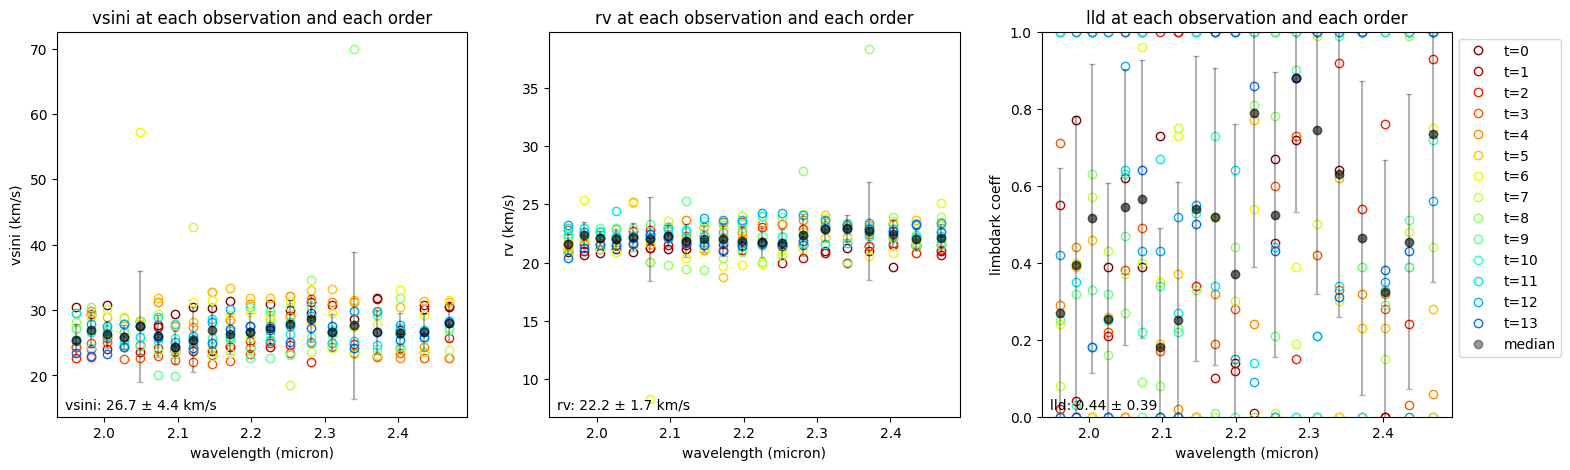

In [6]:
# Plot vsini and rv for bestfittin model - all
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
colors = [cm.jet_r(x) for x in np.linspace(0, 1, nobs+4)]
vsini_points = vsini_2d
rv_points = rv_2d
lld_points = lld_2d
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl

for i, t in enumerate(indices):
    plt.plot(lam_points[:], vsini_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(vsini_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(vsini_points, axis=0), yerr=np.nanstd(vsini_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("vsini (km/s)")
plt.title("vsini at each observation and each order")
plt.text(0.02, 0.02, f"vsini: {np.nanmedian(vsini_points):.1f} ± {np.nanstd(vsini_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,2)
for i, t in enumerate(indices):
    plt.plot(lam_points, rv_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(rv_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(rv_points, axis=0), yerr=np.nanstd(rv_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("rv (km/s)")
plt.title("rv at each observation and each order")
plt.text(0.02, 0.02, f"rv: {np.nanmedian(rv_points):.1f} ± {np.nanstd(rv_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,3)
for i, t in enumerate(indices):
    plt.plot(lam_points, lld_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(lld_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(lld_points, axis=0), yerr=np.nanstd(lld_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("limbdark coeff")
plt.ylim(0, 1.)
plt.title("lld at each observation and each order")
plt.text(0.02, 0.02, f"lld: {np.nanmedian(lld_points):.2f} ± {np.nanstd(lld_points):.2f}", transform=plt.gca().transAxes)
plt.legend(loc=2, bbox_to_anchor=(1,1));

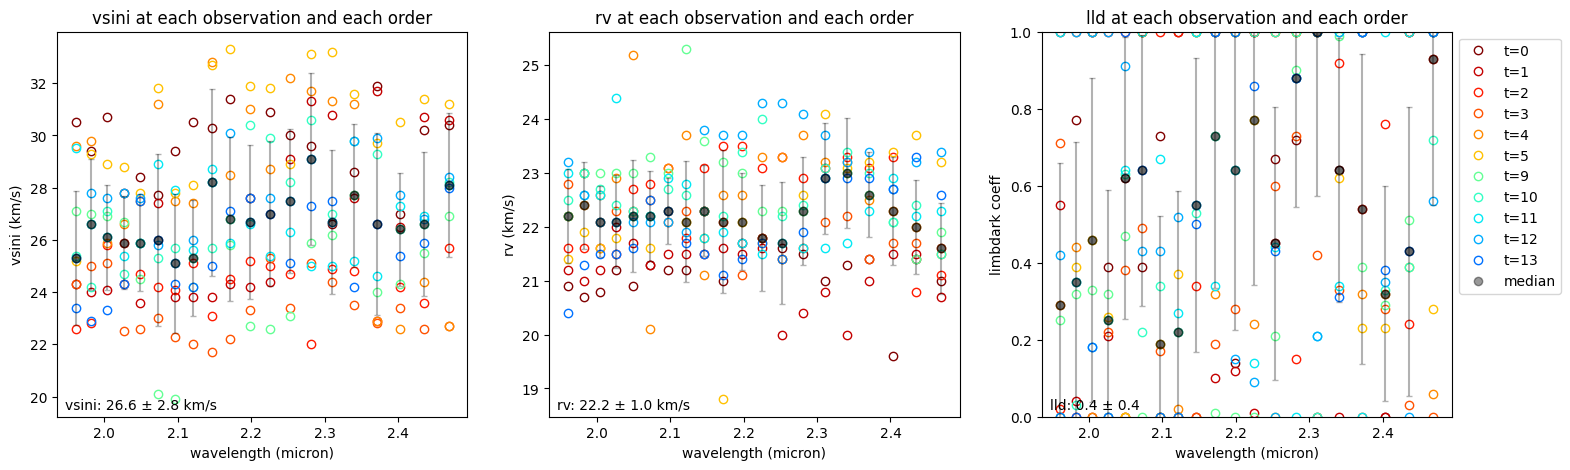

In [112]:
# Plot vsini and rv for bestfittin model
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
colors = [cm.jet_r(x) for x in np.linspace(0, 1, nobs+4)]
vsini_points = masked_vsini
rv_points = masked_rv
lld_points = masked_lld
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl

for i, t in enumerate(indices_masked):
    plt.plot(lam_points[:], vsini_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(vsini_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(vsini_points, axis=0), yerr=np.nanstd(vsini_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("vsini (km/s)")
plt.title("vsini at each observation and each order")
plt.text(0.02, 0.02, f"vsini: {np.nanmedian(vsini_points):.1f} ± {np.nanstd(vsini_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,2)
for i, t in enumerate(indices_masked):
    plt.plot(lam_points, rv_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(rv_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(rv_points, axis=0), yerr=np.nanstd(rv_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("rv (km/s)")
plt.title("rv at each observation and each order")
plt.text(0.02, 0.02, f"rv: {np.nanmedian(rv_points):.1f} ± {np.nanstd(rv_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,3)
for i, t in enumerate(indices_masked):
    plt.plot(lam_points, lld_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(lld_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(lld_points, axis=0), yerr=np.nanstd(lld_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("limbdark coeff")
plt.ylim(0,1.)
plt.title("lld at each observation and each order")
plt.text(0.02, 0.02, f"lld: {np.nanmedian(lld_points):.1f} ± {np.nanstd(lld_points):.1f}", transform=plt.gca().transAxes)
plt.legend(loc=2, bbox_to_anchor=(1,1));

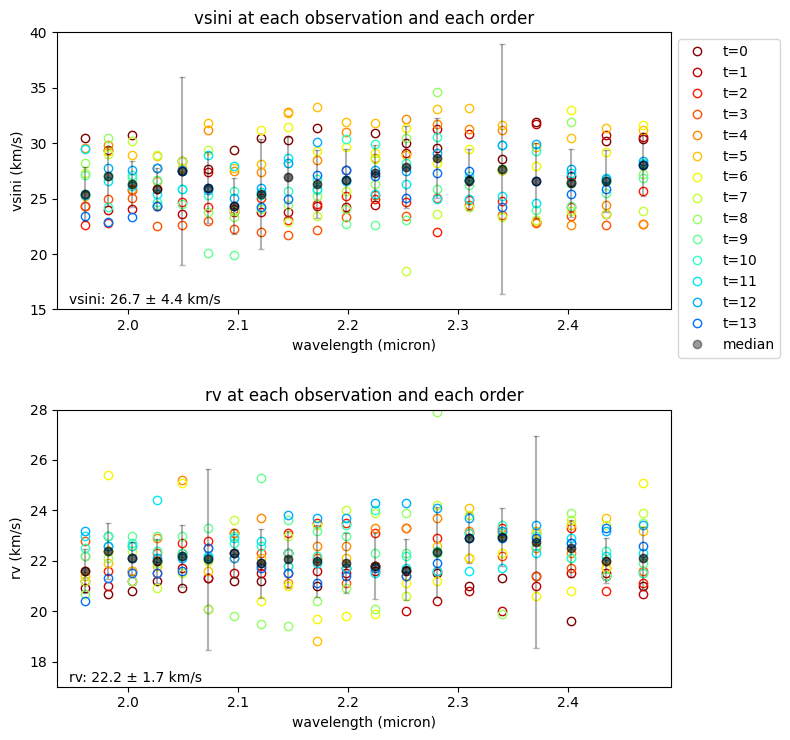

In [141]:
# Plot vsini and rv for bestfittin model - all
plt.figure(figsize=(8,7.5))
plt.subplot(2,1,1)
colors = [cm.jet_r(x) for x in np.linspace(0, 1, nobs+4)]
vsini_points = vsini_2d
rv_points = rv_2d
lld_points = lld_2d
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl

for i, t in enumerate(indices):
    plt.plot(lam_points[:], vsini_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(vsini_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(vsini_points, axis=0), yerr=np.nanstd(vsini_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("vsini (km/s)")
plt.ylim(15,40)
plt.title("vsini at each observation and each order")
plt.text(0.02, 0.02, f"vsini: {np.nanmedian(vsini_points):.1f} ± {np.nanstd(vsini_points):.1f} km/s", transform=plt.gca().transAxes)
plt.legend(loc=2, bbox_to_anchor=(1,1));

plt.subplot(2,1,2)
for i, t in enumerate(indices):
    plt.plot(lam_points, rv_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(rv_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(rv_points, axis=0), yerr=np.nanstd(rv_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("rv (km/s)")
plt.ylim(17,28)
plt.title("rv at each observation and each order")
plt.text(0.02, 0.02, f"rv: {np.nanmedian(rv_points):.1f} ± {np.nanstd(rv_points):.1f} km/s", transform=plt.gca().transAxes)

plt.tight_layout()

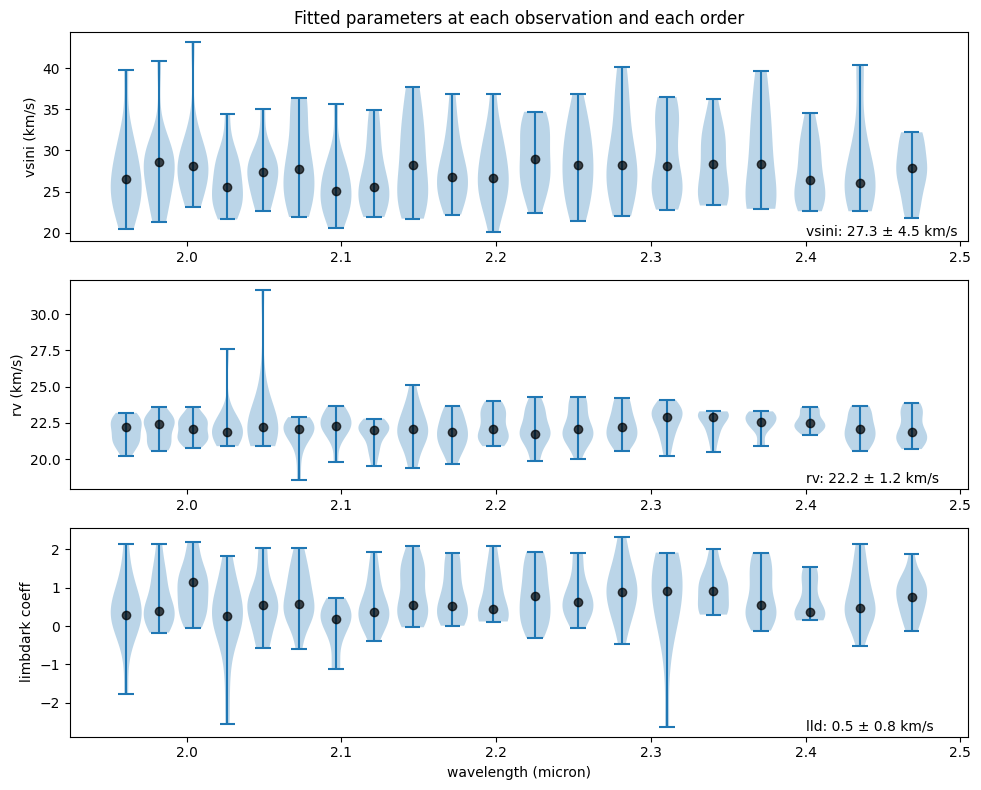

In [101]:
def filtnan(data):
    mask = ~np.isnan(data)
    return [d[m] for d, m in zip(data.T, mask.T)]
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.violinplot(filtnan(vsini_2d), positions=lam_points, widths=0.02)
plt.plot(lam_points, np.nanmedian(vsini_2d, axis=0), "o", label="median", color="k", alpha=0.7)
plt.ylabel("vsini (km/s)")
plt.title("Fitted parameters at each observation and each order")
plt.text(0.82, 0.03, f"vsini: {np.nanmedian(vsini_2d)} ± {np.nanstd(vsini_2d):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(3,1,2)
plt.violinplot(filtnan(rv_2d), positions=lam_points, widths=0.02)
plt.plot(lam_points, np.nanmedian(rv_2d, axis=0), "o", label="median", color="k", alpha=0.7)
plt.ylabel("rv (km/s)")
plt.text(0.82, 0.03, f"rv: {np.nanmedian(rv_2d)} ± {np.nanstd(rv_2d):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(3,1,3)
plt.violinplot(filtnan(lld_2d), positions=lam_points, widths=0.02)
plt.plot(lam_points, np.nanmedian(lld_2d, axis=0), "o", label="median", color="k", alpha=0.7)
plt.xlabel("wavelength (micron)")
plt.ylabel("limbdark coeff")
plt.text(0.82, 0.03, f"lld: {np.nanmedian(lld_2d):.1f} ± {np.nanstd(lld_2d):.1f} km/s", transform=plt.gca().transAxes)

plt.tight_layout()

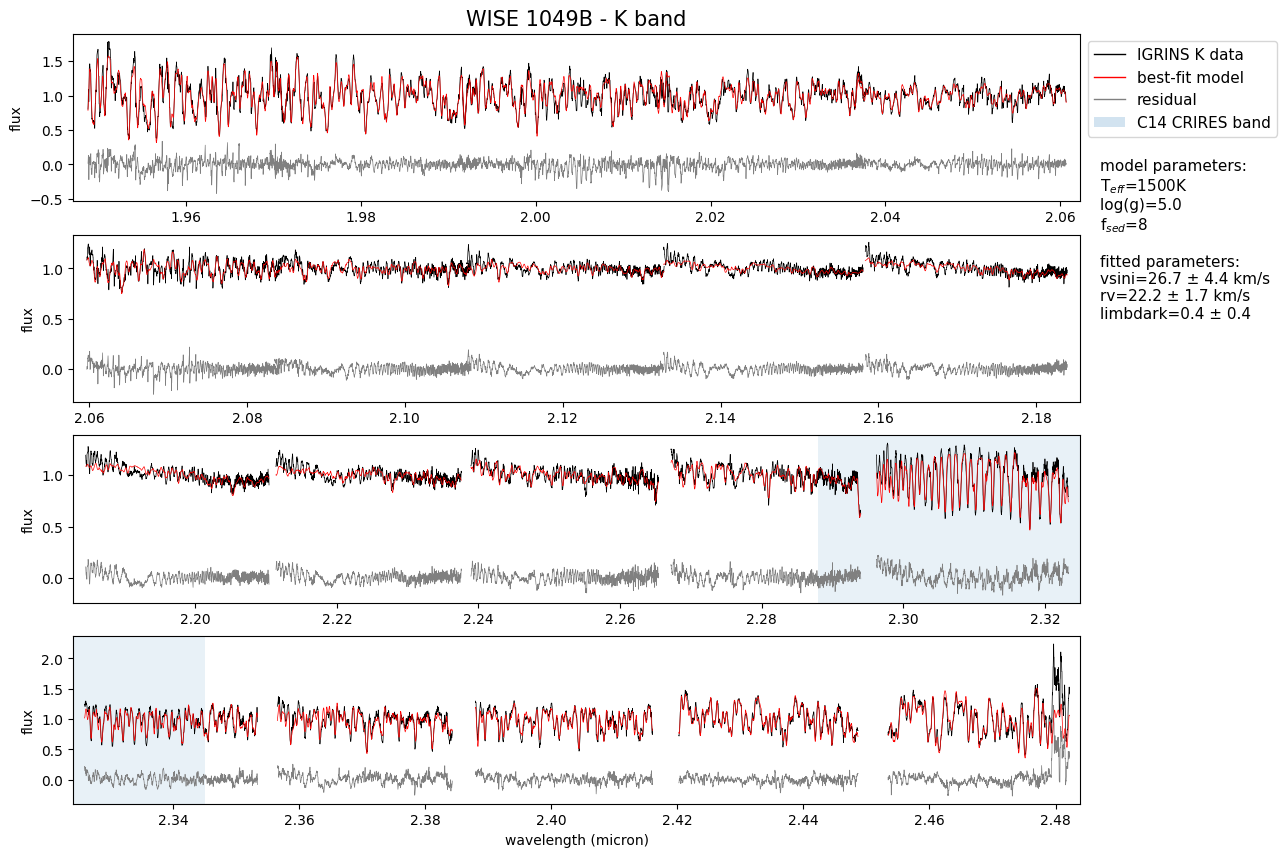

In [19]:
# plot best fitting spectrum
pad = 50
bfit_filename = f'IGRINS_W1049B_K_{model}.pickle'
with open(f"{datadir}/{bfit_filename}", 'rb') as f:
    ret = pickle.load(f, encoding="latin1")
fobs = ret['fobs0']
fobs = fobs[:20]
wobs = ret['wobs']
plt.figure(figsize=(13,10))
Teff = eval(model[1:5])
logg = 5.0

t=0
for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj, pad:-pad], linewidth=0.5, color="black", label="observation")
        plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj,pad:-pad] - chipmods[model][t,jj,pad:-pad], linewidth=0.5, color="gray", label="residual")
        if jj in indices:
            plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="best-fit model")
        else:
            plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="discarded orders")
    plt.ylabel("flux")
    l, r = plt.xlim(chiplams[model][t,sub*5+4].min()-0.001, chiplams[model][t,sub*5].max()+0.001)
    #plt.ylim(-0.5,1.7)
    if sub==1:
        plt.axvspan(2.288, r, alpha=0.1)
    if sub==0:
        plt.axvspan(l, 2.345, alpha=0.1)
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1, label="IGRINS K data"),
                        Line2D([0], [0], color="r", lw=1, label="best-fit model"),
                        Line2D([0], [0], color="grey", lw=1, label="residual"),
                        #Line2D([0], [0], color="magenta", lw=1, label="discarded orders"),
                        Patch(facecolor='tab:blue', alpha=0.2, label="C14 CRIRES band")
                        ]
        plt.legend(handles=custom_lines, loc=2, bbox_to_anchor=(1,1), fontsize=11)

plt.title("WISE 1049B - K band", fontsize=15)
plt.text(x=1.02, y=-0.7, s="model parameters: \nT$_{eff}$="+f"{Teff:.0f}K \nlog(g)={logg} \n"+"f$_{sed}$=8\n" + 
                        f"\nfitted parameters: \nvsini={np.nanmedian(vsini_2d)} ± {np.nanstd(vsini_2d):.1f} km/s" +
                        f"\nrv={np.nanmedian(rv_2d)} ± {np.nanstd(rv_2d):.1f} km/s" +
                        f"\nlimbdark={np.nanmedian(lld_2d):.1f} ± {np.nanstd(lld_2d):.1f}",
        fontsize=11, transform=plt.gca().transAxes)
plt.savefig(f"{homedir}/uoedrive/result/paper1/specK.png", transparent=True, dpi=200, bbox_inches="tight")

In [30]:
22.23/c

7.415141164540749e-05